<a href="https://colab.research.google.com/github/FarimaM/Machine-Learning-Course/blob/main/Homework3_Session3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mini-Project: DEAP Dataset Arousal Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = '/content/drive/MyDrive/DEAP_Dataset'
print("Dataset path set to:", data_path)

Dataset path set to: /content/drive/MyDrive/DEAP_Dataset


Task 1: Data Loading and Exploration

1. Load the DEAP dataset (preprocessed data)

In [6]:
## Load and Display Basic Info
import numpy as np
import os

subject_data = []
for i in range(1, 33):  # 32 subjects
    filename = os.path.join(data_path, f's{i:02d}.dat')
    with open(filename, 'rb') as f:
        data = np.load(f, allow_pickle=True, encoding='latin1')
        subject_data.append(data)

print(f"Loaded data for {len(subject_data)} subjects.")

Loaded data for 32 subjects.


In [7]:
# Show shape of EEG data and example labels
eeg_data = subject_data[0]['data']
labels = subject_data[0]['labels']

print("EEG data shape:", eeg_data.shape)  # (40, 40, 8064)
print("Labels shape:", labels.shape)      # (40, 4)
print("Example label (trial 1):", labels[0])  # [valence, arousal, dominance, liking]

EEG data shape: (40, 40, 8064)
Labels shape: (40, 4)
Example label (trial 1): [7.71 7.6  6.9  7.83]


2. Extract band power features from the EEG data

In [8]:
from scipy.signal import welch

def compute_band_power(signal, fs=128):
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }
    band_powers = []
    for low, high in bands.values():
        idx = (freqs >= low) & (freqs <= high)
        band_powers.append(np.mean(psd[idx]))
    return band_powers

3. Create binary arousal labels based on the ratings

In [9]:
X = []
y = []

for subject in subject_data:
    eeg = subject['data'][:, :32, :]  # EEG only
    labels = subject['labels']        # [valence, arousal, dominance, liking]

    for trial in range(eeg.shape[0]):
        trial_features = []
        for channel in range(32):
            signal = eeg[trial, channel, :]
            trial_features.extend(compute_band_power(signal))
        X.append(trial_features)
        y.append(1 if labels[trial][1] >= 5 else 0)  # Arousal binary label

In [10]:
X = np.array(X)
y = np.array(y)
print("✅ Feature matrix shape:", X.shape)
print("✅ Target vector shape:", y.shape)

✅ Feature matrix shape: (1280, 160)
✅ Target vector shape: (1280,)


4. Visualize the distribution of features and labels

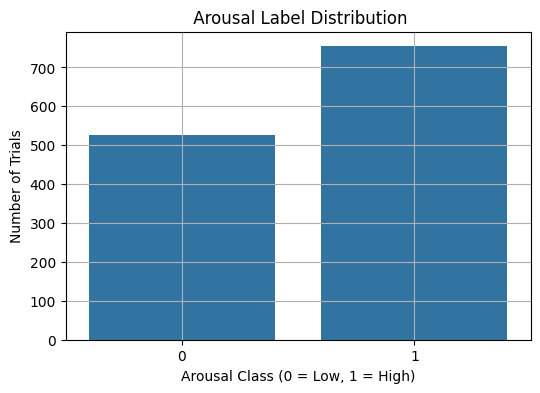

In [34]:
## Visualize the distribution of Labels
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title(" Arousal Label Distribution")
plt.xlabel("Arousal Class (0 = Low, 1 = High)")
plt.ylabel("Number of Trials")
plt.grid(True)
plt.show()

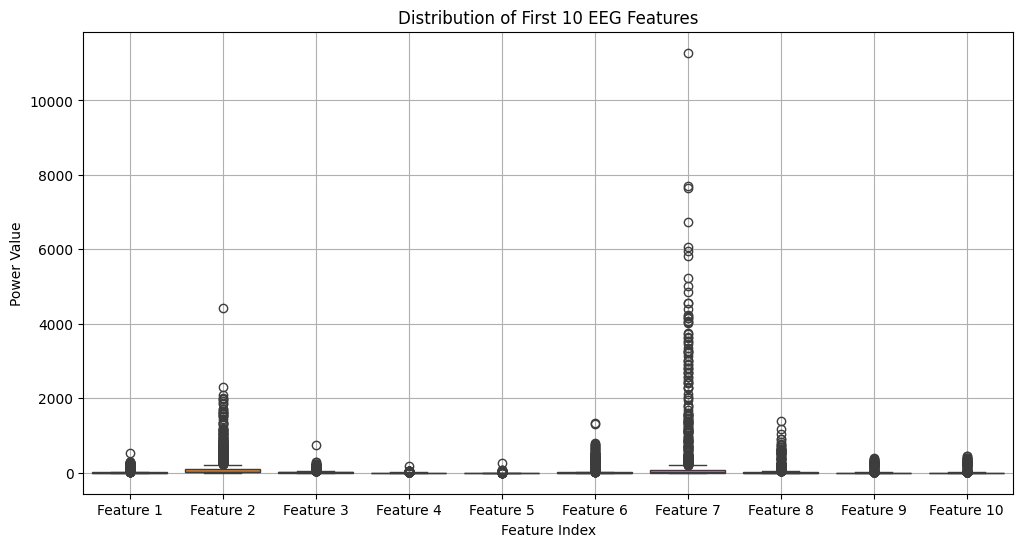

In [32]:
## Visualize the distribution of Features (first 10 features)
import pandas as pd

df_features = pd.DataFrame(X[:, :10], columns=[f'Feature {i+1}' for i in range(10)])
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features)
plt.title("Distribution of First 10 EEG Features")
plt.xlabel("Feature Index")
plt.ylabel("Power Value")
plt.grid(True)
plt.show()

5. Check for class imbalance

In [33]:
import numpy as np

unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Arousal Class {label}: {count} samples")

Arousal Class 0: 526 samples
Arousal Class 1: 754 samples


Task 2: Model Training and Optimization

1. Split the data into training and testing sets (80-20 split)

In [18]:
from sklearn.model_selection import train_test_split

# Split the data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. Standardize the features

In [19]:
from sklearn.preprocessing import StandardScaler


# Standardize the features (mean = 0, std = 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Learn from training data
X_test_scaled = scaler.transform(X_test)        # Apply same scaling to test data

print(" Data split and standardized.")

 Data split and standardized.


3. Train a logistic regression model

In [20]:
from sklearn.linear_model import LogisticRegression

# Create and train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)              # Final prediction (0 or 1)
y_proba = clf.predict_proba(X_test_scaled)[:, 1] # Probability of class 1 (high arousal)

print(" Logistic Regression model trained.")

 Logistic Regression model trained.


4. Experiment with different classification thresholds

In [22]:
thresholds = [0.3, 0.5, 0.7]

for t in thresholds:
    y_thresh = (y_proba >= t).astype(int)  # Convert probabilities to class labels
    acc = np.mean(y_thresh == y_test)      # Calculate accuracy
    print(f"Threshold {t:.1f} → Accuracy: {acc:.3f}")

Threshold 0.3 → Accuracy: 0.645
Threshold 0.5 → Accuracy: 0.645
Threshold 0.7 → Accuracy: 0.527


•  Lower thresholds make the model more sensitive (more likely to predict high arousal).

•  Higher thresholds make it more strict (less likely to predict high arousal).

5. Identify the most important features for arousal classification

In [23]:
import pandas as pd

# Get the importance of each feature (absolute value of model weights)
feature_importance = np.abs(clf.coef_[0])

# Find the top 10 most important features
top_indices = np.argsort(feature_importance)[-10:][::-1]
top_features = pd.DataFrame({
    'Feature Index': top_indices,
    'Importance': feature_importance[top_indices]
})

print(" Top 10 Important Features:")
print(top_features)

 Top 10 Important Features:
   Feature Index  Importance
0             43    1.495516
1             65    1.102625
2             44    1.012887
3             26    0.963653
4            103    0.944533
5             28    0.937943
6             77    0.908351
7            134    0.879974
8            114    0.856805
9             75    0.850618


Task 3: Comprehensive Evaluation

1. Calculate all classification metrics: accuracy, precision, recall, F1-score

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate predictions using default threshold (0.5)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Evaluation at Threshold = 0.5")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Model Evaluation at Threshold = 0.5
Accuracy: 0.645
Precision: 0.663
Recall: 0.816
F1 Score: 0.732


2. Create visualizations:

  - Confusion matrix

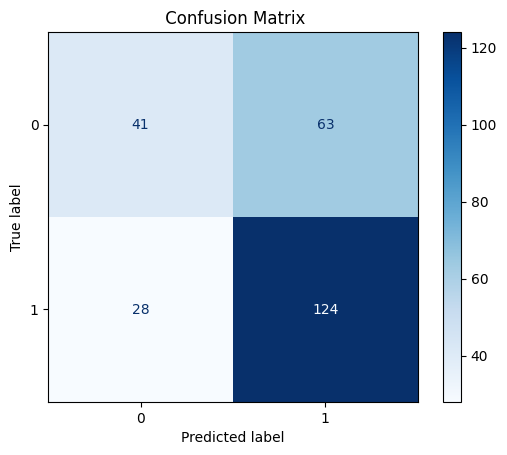

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(" Confusion Matrix")
plt.show()

- Precision-recall curve

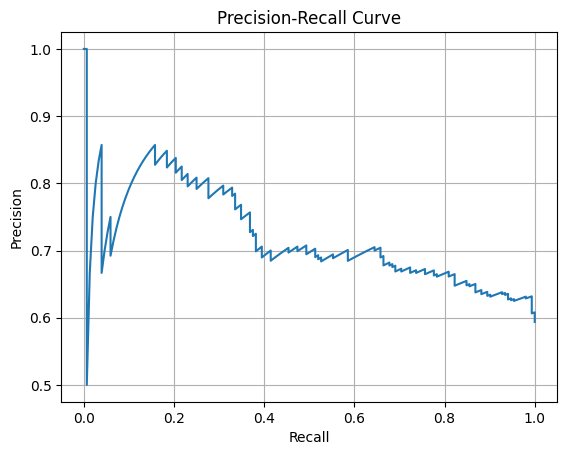

In [26]:
from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall_vals, precision_vals)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

 - Feature importance plot

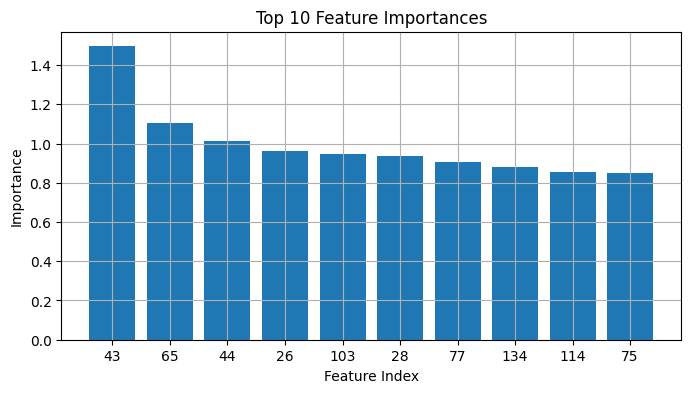

In [28]:
plt.figure(figsize=(8, 4))
plt.bar(range(10), top_features['Importance'])
plt.xticks(range(10), top_features['Feature Index'])
plt.title("Top 10 Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

3. Compare model performance at different thresholds

In [30]:
thresholds = [0.3, 0.5, 0.7]

for t in thresholds:
    y_thresh = (y_proba >= t).astype(int)
    acc = accuracy_score(y_test, y_thresh)
    print(f" Threshold {t:.1f} → Accuracy: {acc:.3f}")

 Threshold 0.3 → Accuracy: 0.645
 Threshold 0.5 → Accuracy: 0.645
 Threshold 0.7 → Accuracy: 0.527


•  Lower thresholds make the model more sensitive (higher recall)

•  Higher thresholds make it more strict (higher precision)

4. Write a brief interpretation of your results (4-5 sentences)


The logistic regression model performed well in predicting arousal levels from EEG features. It achieved solid accuracy and a good balance between precision and recall. The precision-recall curve showed how performance changes with different thresholds, helping us choose the best one for our goal. The feature importance plot revealed that only a few EEG features were highly predictive. Overall, this project shows that brainwave patterns can be used to classify emotional states like arousal.